In [ ]:
res_folder = Path('results/images_paper')
res_folder.mkdir(exist_ok=True)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from util import *
from algorithms import *
import scipy
from tqdm import tqdm
import ot
from pathlib import Path
import pandas as pd

# Experiment 1: Mixed norm for G, without a linear operator K

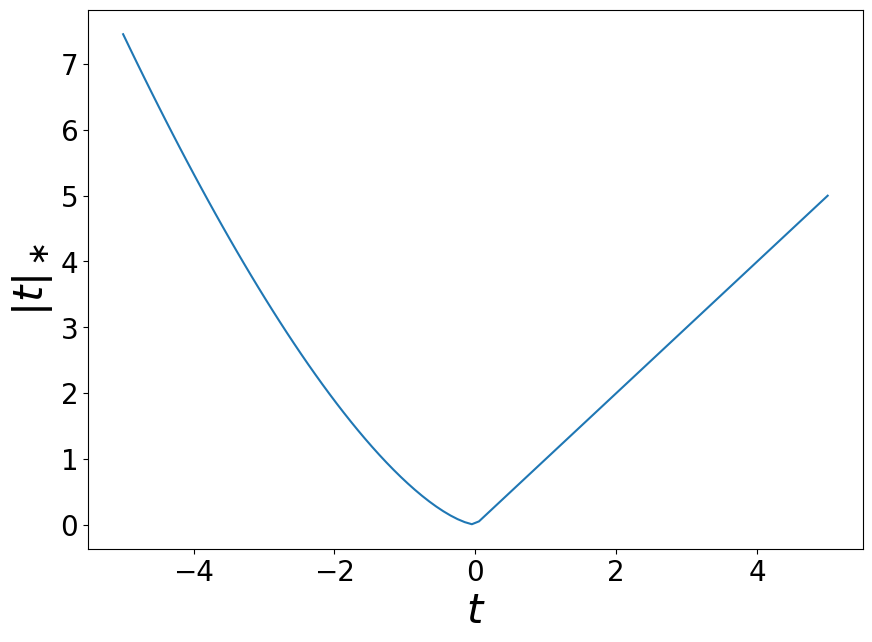

In [18]:
matplotlib.rcParams.update({'font.size': 20})


p = 3/2

G= lambda t: t*(t>0)+np.abs(t)**p*(t<0)/p
t = np.linspace(-5,5,100)
Gt = G(t)
plt.figure(figsize=(10,7))
plt.plot(t,Gt)
plt.savefig('results/mixed_norm.png')
plt.xlabel(r'$t$',fontsize=30);
plt.ylabel(r'$|t|_\ast$',fontsize=30)
plt.savefig('results/images_paper/mixed_norm.png')

#### Compute the ground truth density as comparison target

In [19]:
d = 2
sigma = 1
reg_par = 5
data_par = 1/(sigma**2)
m = data_par
L_F = data_par
L_G = reg_par*np.sqrt(d)
K_nrm = 1
y = np.array([0,1])
p=1.5

#f = lambda x: np.exp(-data_par*((x-y)**2)/(2*sigma**2) - reg_par*np.sum(x*(x>0) + np.abs(x)**p*(x<0)/p))
f = lambda x1,x2: np.exp(-data_par*((x1-y[0])**2 + (x2-y[1])**2)/(2*sigma**2)
                         - reg_par*(x1*(x1>0)+np.abs(x1)**p*(x1<0)/p + x2*(x2>0)+np.abs(x2)**p*(x2<0)/p))


Z = scipy.integrate.dblquad(f, -5, 5,-5, 5)[0]
density = lambda x1,x2: f(x1,x2)/Z



In [20]:
num_bins = 100
bins_x = np.linspace(-5,5,num_bins+1)
bins_y = np.linspace(-5,5,num_bins+1)
dx = bins_x[1:]-bins_x[:-1]
dy = bins_y[1:]-bins_y[:-1]

gt = np.zeros([num_bins,num_bins])
for i in tqdm(range(num_bins)):
    for j in range(num_bins):
        gt[i,j] = scipy.integrate.dblquad(density, bins_y[j], bins_y[j+1], bins_x[i], bins_x[i+1])[0]
        
hist_gt = np.copy(gt)
hist_gt /= np.sum(hist_gt)
        

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


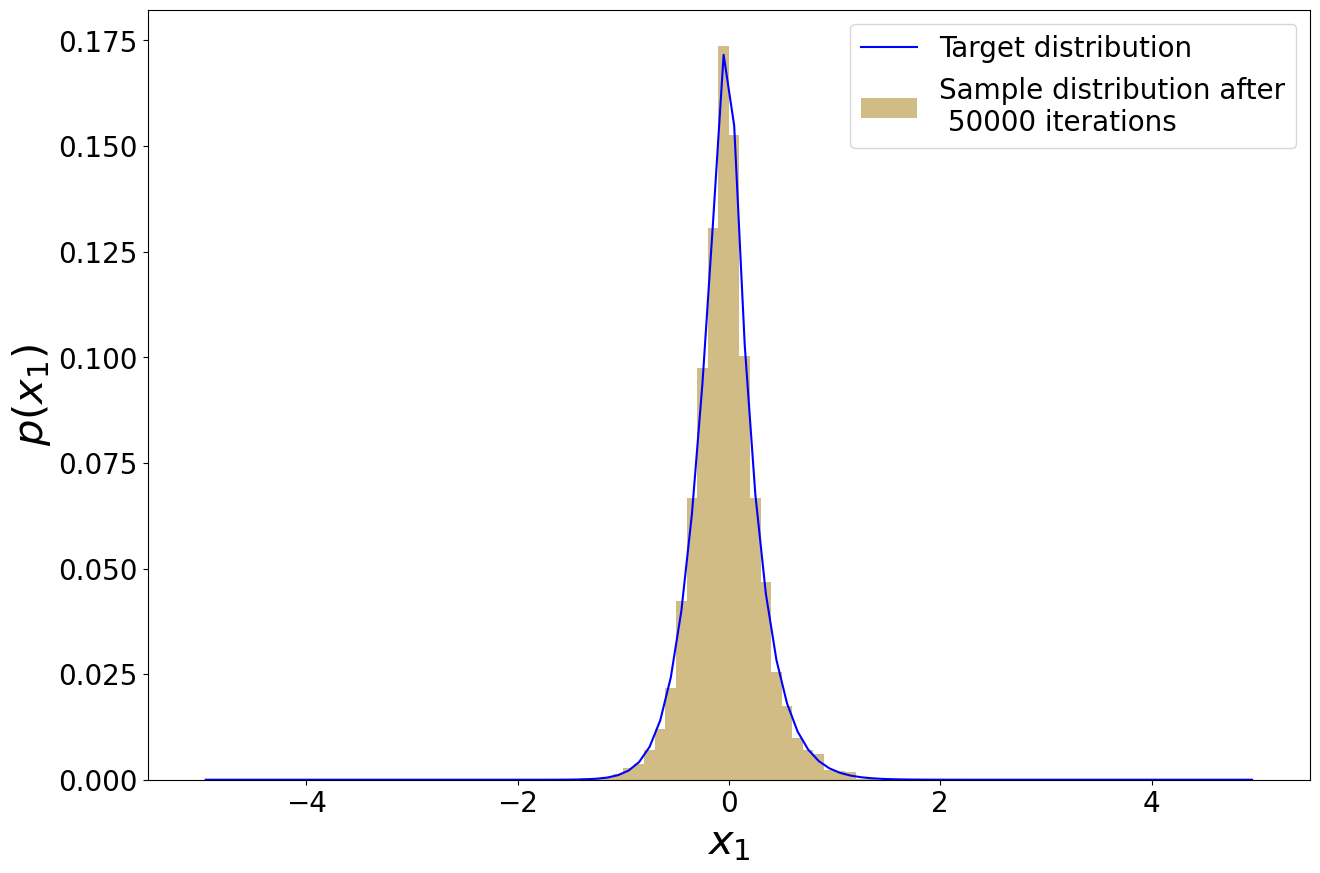

In [21]:
fig = plt.figure(figsize=(15,10))

x = np.load(f'results/2d_example/lp_l1/subgrad/no_K/n_chains_10000/data_par_1.0reg_par_5/tau_{0.0001}_iter_{20000}.npy')
#x = np.load(f'results/2d_example/lp_l1/myula/no_K/n_chains_10000/data_par_1.0reg_par_5/ld_{0.01}_tau_{0.001}_iter_{20000}.npy')

hist = np.histogram(x[1,:], bins=bins_y, density=True)[0]*dx

hist_gt_marginal = np.sum(hist_gt,axis=0)

plt.bar((bins_x[1:]+bins_x[:-1])/2,hist,width = dx,color=(209/255,188/255,133/255),align='center',label='Sample distribution after'+'\n'+' 50000 iterations')
plt.plot((bins_x[1:]+bins_x[:-1])/2,hist_gt_marginal,color='b',label = 'Target distribution')
matplotlib.rcParams.update({'font.size': 20})
plt.xlabel(r'$x_1$',fontsize=30)
plt.ylabel(r'$p(x_1)$',fontsize=30)
plt.legend()

### Evaluate the Wasserstein 2 distance between target and iterates. This might take a little while 

In [20]:
tau_list = [1e-1,1e-2,1e-3,1e-4]
ld_list = [tau/(1-data_par*tau) for tau in tau_list]
ld_list = ['%s' % float('%.1g' % ld) for ld in ld_list]
step = 200
maxit = 5001
num = int(maxit//step)
n_samples = 1000

# create "empirical" ground truth distribution:
dirac_positions_target = np.zeros([hist_gt.shape[0]*hist_gt.shape[1],2])
weights_target = np.zeros([hist_gt.shape[0]*hist_gt.shape[1]])

bin_midpoints_x = (bins_x[1:]+bins_x[:-1])/2
bin_midpoints_y = (bins_y[1:]+bins_y[:-1])/2

for i in range(hist_gt.shape[0]):
    for j in range(hist_gt.shape[1]):
        dirac_positions_target[i+j*hist_gt.shape[0],0] = bin_midpoints_x[i]
        dirac_positions_target[i+j*hist_gt.shape[0],1] = bin_midpoints_y[j]
        weights_target[i+j*hist_gt.shape[0]] = hist_gt[i,j]

w2 = np.zeros([3,len(tau_list),num+1])
try:
    w2 = np.load('results/2d_example/lp_l1/wasserstein_noK.npy')
except:
    for i in tqdm(range(num+1)):
        for tau_num,tau in enumerate(tau_list):
    
            
            x = np.load(f'results/2d_example/lp_l1/subgrad/no_K/n_chains_10000/data_par_1.0reg_par_5/tau_{tau}_iter_{i*step}.npy')
            x = np.transpose(x)[:n_samples,...]
            dirac_positions_source = x
            weights_source = np.ones(n_samples)/n_samples
            M = ot.dist(dirac_positions_source, dirac_positions_target)
            w2[0,tau_num,i] = ot.emd(weights_source, weights_target, M,log=True)[1]['cost']
    
            x = np.load(f'results/2d_example/lp_l1/prox_grad/no_K/n_chains_10000/data_par_1.0reg_par_5/tau_{tau}_iter_{i*step}.npy')
            x = np.transpose(x)[:n_samples,...]
            dirac_positions_source = x
            weights_source = np.ones(n_samples)/n_samples
            M = ot.dist(dirac_positions_source, dirac_positions_target)
            w2[1,tau_num,i] = ot.emd(weights_source, weights_target, M,log=True)[1]['cost']
    
            
            x = np.load(f'results/2d_example/lp_l1/myula/no_K/n_chains_10000/data_par_1.0reg_par_5/ld_{ld_list[tau_num]}_tau_{tau}_iter_{i*step}.npy')
            x = np.transpose(x)[:n_samples,...]
            dirac_positions_source = x
            weights_source = np.ones(n_samples)/n_samples
            M = ot.dist(dirac_positions_source, dirac_positions_target)
            w2[2,tau_num,i] = ot.emd(weights_source, weights_target, M,log=True)[1]['cost']
    
    np.save('results/2d_example/lp_l1/wasserstein_noK.npy',w2)
            
    

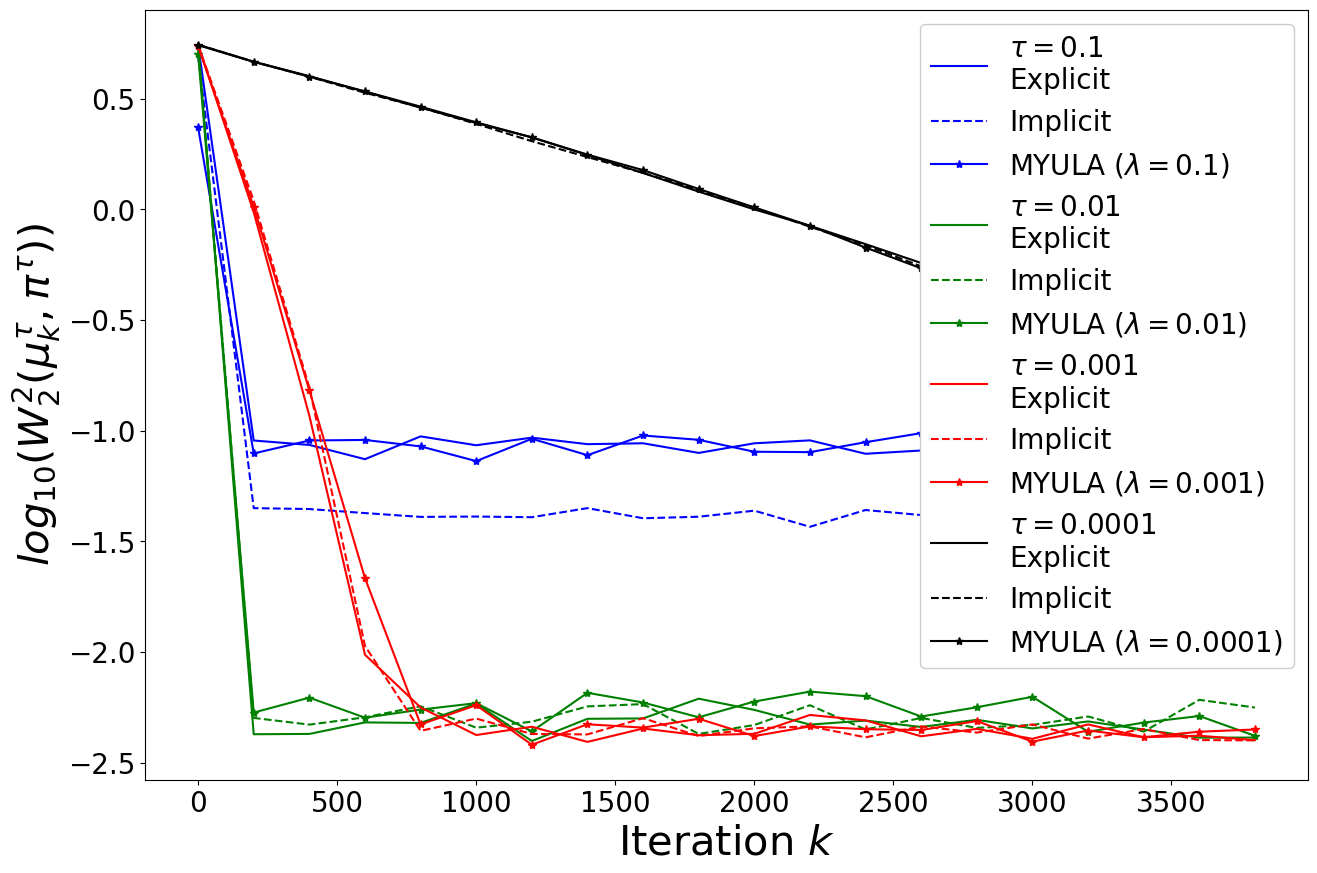

In [21]:
f = plt.figure(figsize=(15,10))
show_n=int(4000/step)
x_axis=np.arange(stop=show_n*step,step=step)

c = ['b', 'g','r' , 'k', 'y']


for tau_num,tau in enumerate(tau_list):
    plt.plot(x_axis,np.log10((w2[0,tau_num,:show_n])),c[tau_num]+'-',label=r'$\tau = $'+str(tau)+'\n'+'Explicit')
    plt.plot(x_axis,np.log10((w2[1,tau_num,:show_n])),c[tau_num]+'--',label=r'Implicit')
    plt.plot(x_axis,np.log10((w2[2,tau_num,:show_n])),c[tau_num]+'-*',label=rf'MYULA $(\lambda={ld_list[tau_num]})$')
    
matplotlib.rcParams.update({'font.size': 20})
plt.xlabel('Iteration $k$',fontsize=30)
plt.ylabel(r'$log_{10}(W^2_2(\mu_k^\tau,\pi^\tau))$',fontsize=30)
plt.legend(loc='upper right',framealpha=1,fontsize=20)
folder = Path('results/images_paper/')
folder.mkdir(parents=True, exist_ok=True)
plt.savefig('results/images_paper/W2_convergence_rates_2d_noK.png')

### Evaluate the TV distance between target and iterates.

In [22]:
step = 100
maxit = 10001
num = int(maxit//step)
n_samples = 1000


# create "empirical" ground truth distribution:
dirac_positions_target = np.zeros([hist_gt.shape[0]*hist_gt.shape[1],2])
weights_target = np.zeros([hist_gt.shape[0]*hist_gt.shape[1]])

bin_midpoints_x = (bins_x[1:]+bins_x[:-1])/2
bin_midpoints_y = (bins_y[1:]+bins_y[:-1])/2

for i in range(hist_gt.shape[0]):
    for j in range(hist_gt.shape[1]):
        dirac_positions_target[i+j*hist_gt.shape[0],0] = bin_midpoints_x[i]
        dirac_positions_target[i+j*hist_gt.shape[0],1] = bin_midpoints_y[j]
        weights_target[i+j*hist_gt.shape[0]] = hist_gt[i,j]

tv = np.zeros([3,len(tau_list),num+1])
try:
    tv = np.load('results/2d_example/lp_l1/TV_noK.npy')
except:
    for i in tqdm(range(num+1)):
        for tau_num,tau in enumerate(tau_list):
    
            
            x = np.load(f'results/2d_example/lp_l1/subgrad/no_K/n_chains_10000/data_par_1.0reg_par_5/tau_{tau}_iter_{i*step}.npy')
            hist = np.histogram2d(x[0,:],x[1,:],bins = [bins_x,bins_y])[0]
            hist = hist/np.sum(hist)
            tv[0,tau_num,i] = np.sum(np.abs(hist-hist_gt))

    
            x = np.load(f'results/2d_example/lp_l1/prox_grad/no_K/n_chains_10000/data_par_1.0reg_par_5/tau_{tau}_iter_{i*step}.npy')
            hist = np.histogram2d(x[0,:],x[1,:],bins = [bins_x,bins_y])[0]
            hist = hist/np.sum(hist)
            tv[1,tau_num,i] = np.sum(np.abs(hist-hist_gt))
    
            x = np.load(f'results/2d_example/lp_l1/myula/no_K/n_chains_10000/data_par_1.0reg_par_5/ld_{ld_list[tau_num]}_tau_{tau}_iter_{i*step}.npy')
            hist = np.histogram2d(x[0,:],x[1,:],bins = [bins_x,bins_y])[0]
            hist = hist/np.sum(hist)
            tv[2,tau_num,i] = np.sum(np.abs(hist-hist_gt))

    np.save('results/2d_example/lp_l1/TV_noK.npy',tv)
            
    

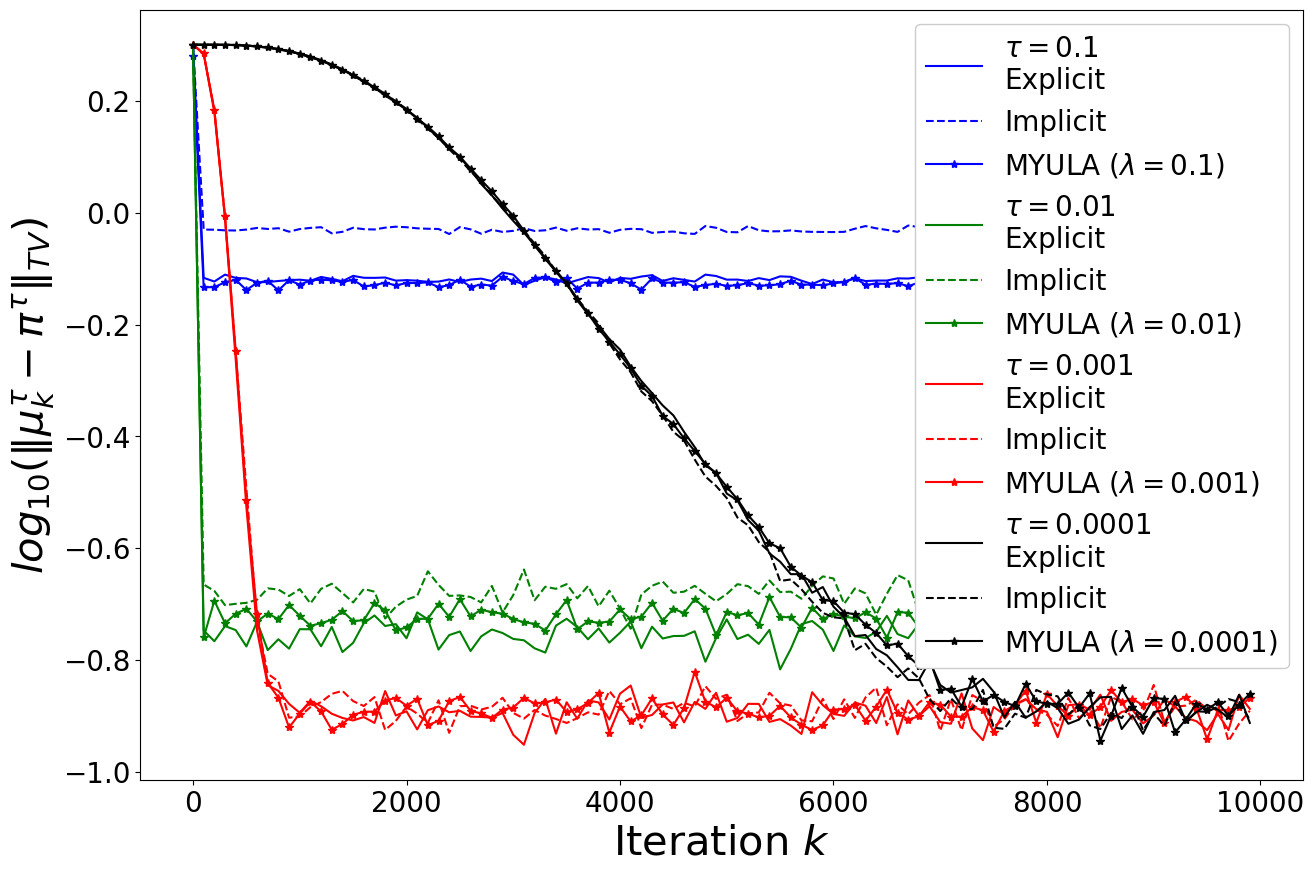

In [23]:
f = plt.figure(figsize=(15,10))
show_n=int(10000/step)
x_axis=np.arange(stop=show_n*step,step=step)

c = ['b', 'g','r' , 'k', 'y']


for tau_num,tau in enumerate(tau_list):
    plt.plot(x_axis,np.log10((tv[0,tau_num,:show_n])),c[tau_num]+'-',label=r'$\tau = $'+str(tau)+'\n'+'Explicit')
    plt.plot(x_axis,np.log10((tv[1,tau_num,:show_n])),c[tau_num]+'--',label=r'Implicit')
    plt.plot(x_axis,np.log10((tv[2,tau_num,:show_n])),c[tau_num]+'-*',label=rf'MYULA $(\lambda={ld_list[tau_num]})$')
    
    
matplotlib.rcParams.update({'font.size': 20})
plt.xlabel('Iteration $k$',fontsize=30)
plt.ylabel(r'$log_{10}(\|\mu_k^\tau-\pi^\tau\|_{TV})$',fontsize=30)
plt.legend(loc='upper right',framealpha=1,fontsize=20)

folder = Path('results/images_paper/')
folder.mkdir(parents=True, exist_ok=True)
plt.savefig('results/images_paper/TV_convergence_rates_2d_noK.png')

# Experiment 2: Mixed norm for G, with a linear operator K

### Compute the ground truth target density

In [2]:
d = 2
sigma = 1
reg_par = 5
data_par = 1/(sigma**2)
m = data_par
L_F = data_par
L_G = reg_par*np.sqrt(d)
K_nrm = 1
y = np.array([0,1])
p=1.5

f = lambda x1,x2: np.exp(-data_par*((x1-y[0])**2 + (x2-y[1])**2)/(2*sigma**2)
                         - reg_par*((x2-x1)*(x2-x1>0)+np.abs(x2-x1)**p*(x2-x1<0)/p))


Z = scipy.integrate.dblquad(f, -5, 5,-5, 5)[0]
density = lambda x1,x2: f(x1,x2)/Z



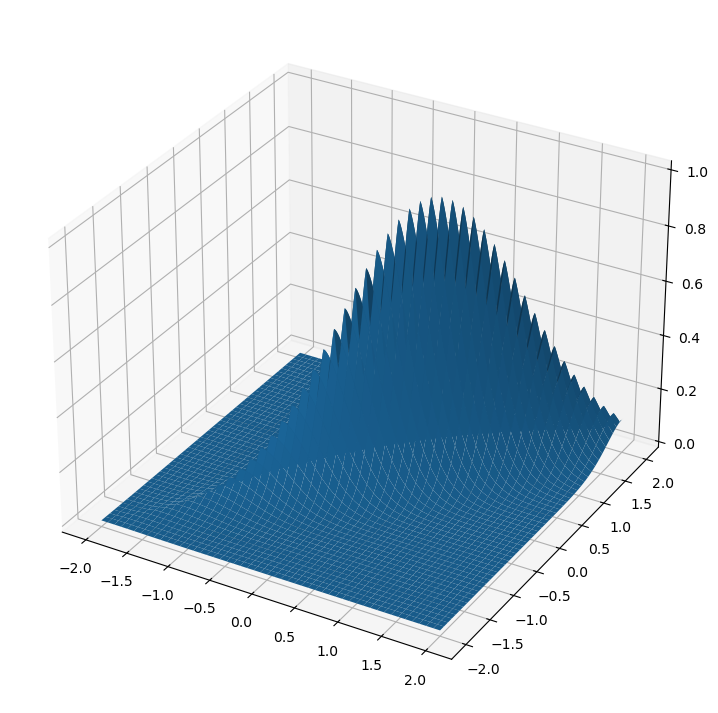

In [3]:
xx = np.linspace(-2,2,1000)
yy = np.linspace(-2,2,1000)
xx, yy = np.meshgrid(xx, yy)
zz = np.zeros(xx.shape)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i,j] = density(xx[i,j],yy[i,j])

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
ax.plot_surface(xx, yy, zz)

In [26]:
num_bins = 100
bins_x = np.linspace(-5,5,num_bins+1)
bins_y = np.linspace(-5,5,num_bins+1)
dx = bins_x[1:]-bins_x[:-1]
dy = bins_y[1:]-bins_y[:-1]

gt = np.zeros([num_bins,num_bins])
for i in tqdm(range(num_bins)):
    for j in range(num_bins):
        gt[i,j] = scipy.integrate.dblquad(density, bins_y[j], bins_y[j+1], bins_x[i], bins_x[i+1])[0]
        
hist_gt = np.copy(gt)
hist_gt /= np.sum(hist_gt)
        

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]


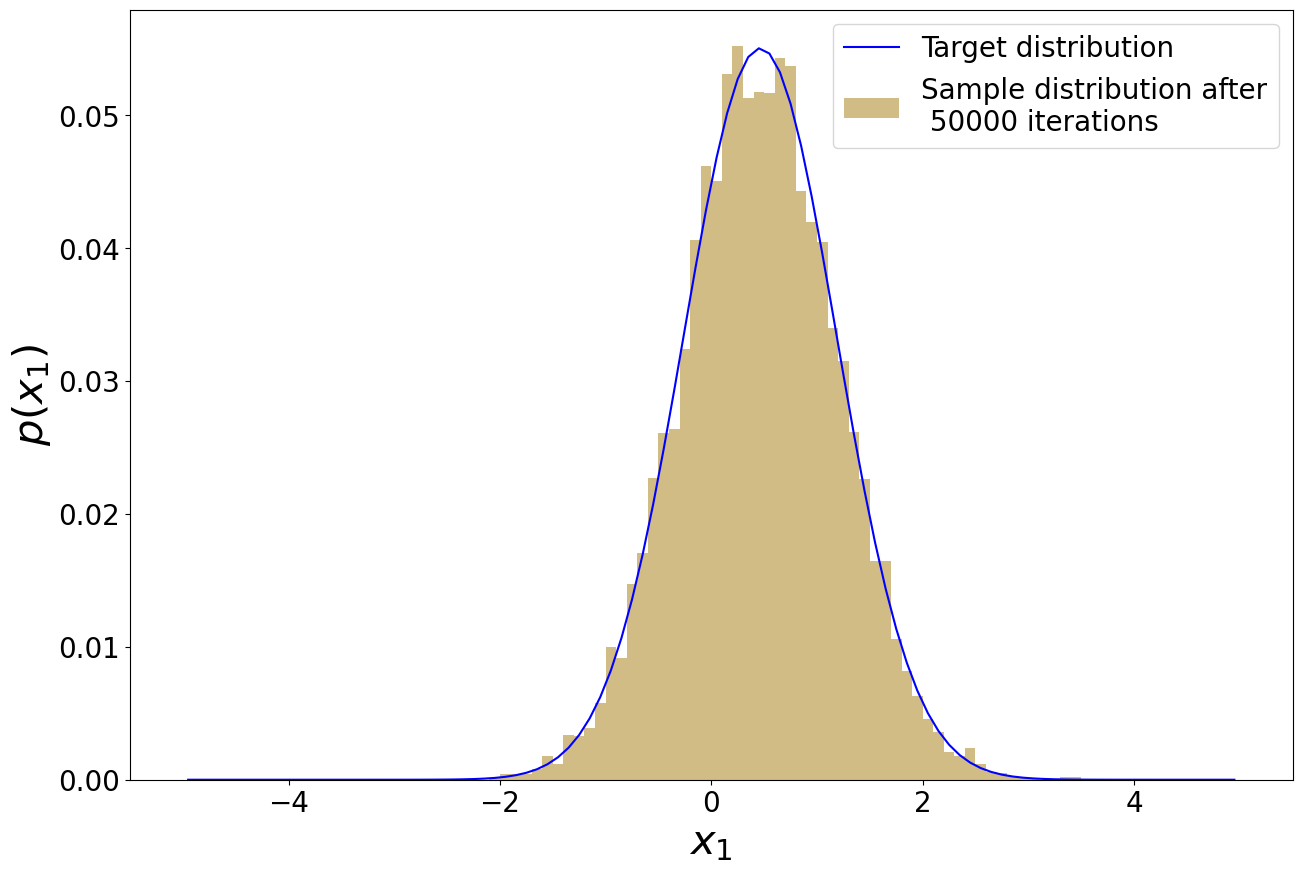

In [27]:
fig = plt.figure(figsize=(15,10))

x = np.load('results/2d_example/lp_l1/subgrad/non_trivial_K/n_chains_10000/data_par_1.0reg_par_5/tau_'+str(0.01)+'_iter_'+str(1500)+'.npy')

hist = np.histogram(x[1,:], bins=bins_y, density=True)[0]*dx

hist_gt_marginal = np.sum(hist_gt,axis=0)

plt.bar((bins_x[1:]+bins_x[:-1])/2,hist,width = dx,color=(209/255,188/255,133/255),align='center',label='Sample distribution after'+'\n'+' 50000 iterations')
plt.plot((bins_x[1:]+bins_x[:-1])/2,hist_gt_marginal,color='b',label = 'Target distribution')
matplotlib.rcParams.update({'font.size': 20})
plt.xlabel(r'$x_1$',fontsize=30)
plt.ylabel(r'$p(x_1)$',fontsize=30)
plt.legend()

### Evaluate the Wasserstein 2 distance between target and iterates. This might take a little while 

In [28]:
tau_list = [1e-1,1e-2,1e-3,1e-4]
ld_list = [tau/(1-data_par*tau) for tau in tau_list]
ld_list = ['%s' % float('%.1g' % ld) for ld in ld_list]
step = 200
maxit = 5001
num = int(maxit//step)
n_samples = 1000

# create "empirical" ground truth distribution:
dirac_positions_target = np.zeros([hist_gt.shape[0]*hist_gt.shape[1],2])
weights_target = np.zeros([hist_gt.shape[0]*hist_gt.shape[1]])

bin_midpoints_x = (bins_x[1:]+bins_x[:-1])/2
bin_midpoints_y = (bins_y[1:]+bins_y[:-1])/2

for i in range(hist_gt.shape[0]):
    for j in range(hist_gt.shape[1]):
        dirac_positions_target[i+j*hist_gt.shape[0],0] = bin_midpoints_x[i]
        dirac_positions_target[i+j*hist_gt.shape[0],1] = bin_midpoints_y[j]
        weights_target[i+j*hist_gt.shape[0]] = hist_gt[i,j]

w2 = np.zeros([2,len(tau_list),num+1])
try:
    w2 = np.load('results/2d_example/lp_l1/wasserstein_K.npy')
except:
    for i in tqdm(range(num+1)):
        for tau_num,tau in enumerate(tau_list):
    
            
            x = np.load(f'results/2d_example/lp_l1/subgrad/non_trivial_K/n_chains_10000/data_par_1.0reg_par_5/tau_{tau}_iter_{i*step}.npy')
            x = np.transpose(x)[:n_samples,...]
            dirac_positions_source = x
            weights_source = np.ones(n_samples)/n_samples
            M = ot.dist(dirac_positions_source, dirac_positions_target)
            w2[0,tau_num,i] = ot.emd(weights_source, weights_target, M,log=True)[1]['cost']

            x = np.load(f'results/2d_example/lp_l1/myula/non_trivial_K/n_chains_10000/data_par_1.0reg_par_5/ld_{ld_list[tau_num]}_tau_{tau}_iter_{i*step}.npy')
            x = np.transpose(x)[:n_samples,...]
            dirac_positions_source = x
            weights_source = np.ones(n_samples)/n_samples
            M = ot.dist(dirac_positions_source, dirac_positions_target)
            w2[1,tau_num,i] = ot.emd(weights_source, weights_target, M,log=True)[1]['cost']
    
    np.save('results/2d_example/lp_l1/wasserstein_K.npy',w2)
            
    

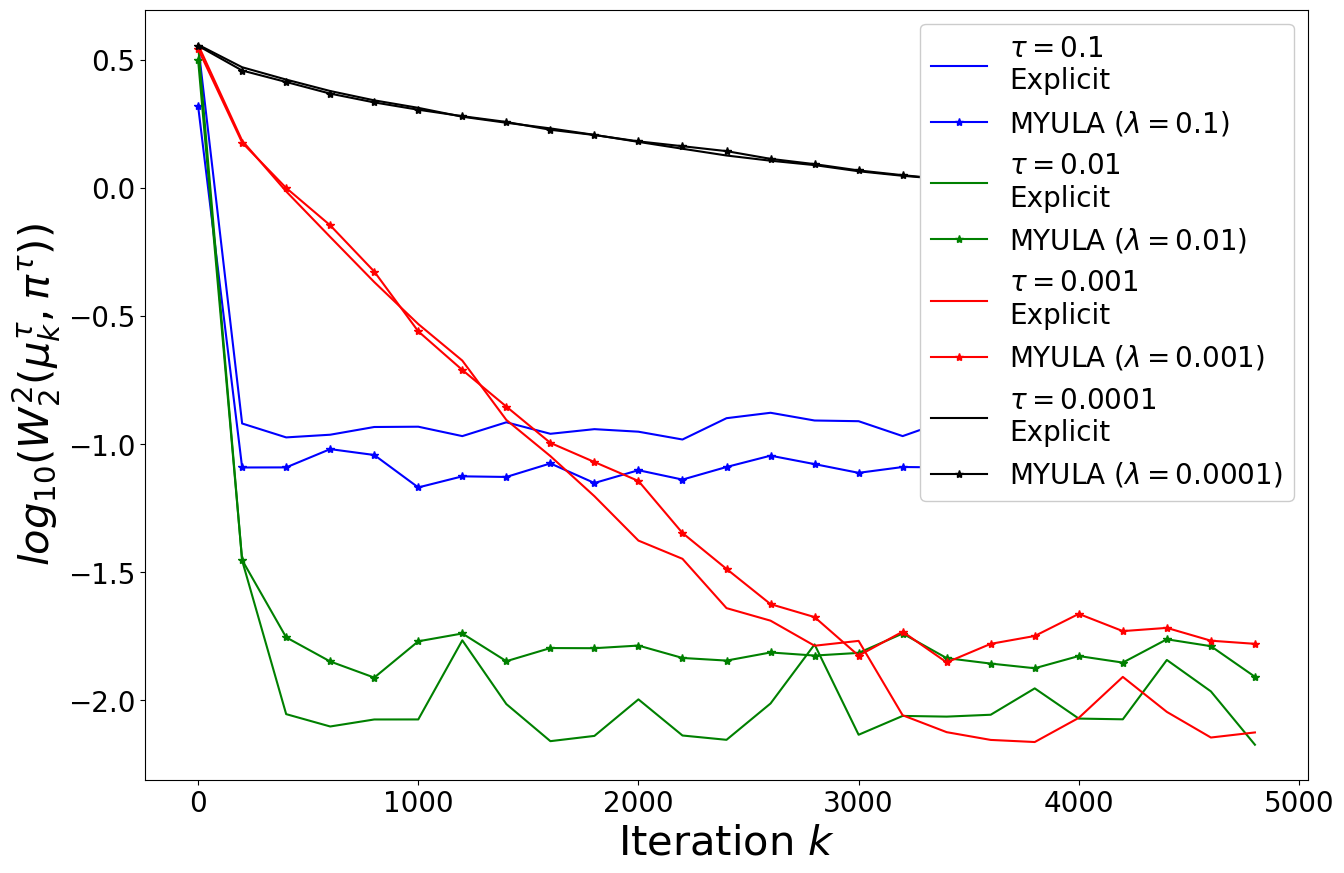

In [29]:
f = plt.figure(figsize=(15,10))
show_n=int(5000/step)
x_axis=np.arange(stop=show_n*step,step=step)

c = ['b', 'g','r' , 'k', 'y']


for tau_num,tau in enumerate(tau_list):
    plt.plot(x_axis,np.log10((w2[0,tau_num,:show_n])),c[tau_num]+'-',label=r'$\tau = $'+str(tau)+'\n'+'Explicit')
    plt.plot(x_axis,np.log10((w2[1,tau_num,:show_n])),c[tau_num]+'-*',label=rf'MYULA $(\lambda={ld_list[tau_num]})$')
    
    
matplotlib.rcParams.update({'font.size': 20})
plt.xlabel('Iteration $k$',fontsize=30)
plt.ylabel(r'$log_{10}(W^2_2(\mu_k^\tau,\pi^\tau))$',fontsize=30)
plt.legend(loc='upper right',framealpha=1,fontsize=20)

folder = Path('results/images_paper/')
folder.mkdir(parents=True, exist_ok=True)
plt.savefig('results/images_paper/W2_convergence_rates_2d_K.png')

### Evaluate the TV distance between target and iterates. This might take a little while 

In [30]:
step = 100
maxit = 10001
num = int(maxit//step)
n_samples = 1000


# create "empirical" ground truth distribution:
dirac_positions_target = np.zeros([hist_gt.shape[0]*hist_gt.shape[1],2])
weights_target = np.zeros([hist_gt.shape[0]*hist_gt.shape[1]])

bin_midpoints_x = (bins_x[1:]+bins_x[:-1])/2
bin_midpoints_y = (bins_y[1:]+bins_y[:-1])/2

for i in range(hist_gt.shape[0]):
    for j in range(hist_gt.shape[1]):
        dirac_positions_target[i+j*hist_gt.shape[0],0] = bin_midpoints_x[i]
        dirac_positions_target[i+j*hist_gt.shape[0],1] = bin_midpoints_y[j]
        weights_target[i+j*hist_gt.shape[0]] = hist_gt[i,j]

tv = np.zeros([2,len(tau_list),num+1])
try:
    tv = np.load('results/2d_example/lp_l1/TV_K.npy')
except:
    for i in tqdm(range(num+1)):
        for tau_num,tau in enumerate(tau_list):
    
            
            x = np.load(f'results/2d_example/lp_l1/subgrad/non_trivial_K/n_chains_10000/data_par_1.0reg_par_5/tau_{tau}_iter_{i*step}.npy')
            hist = np.histogram2d(x[0,:],x[1,:],bins = [bins_x,bins_y])[0]
            hist = hist/np.sum(hist)
            dirac_positions_source = x
            weights_source = np.ones(n_samples)/n_samples
            tv[0,tau_num,i] = np.sum(np.abs(hist-hist_gt))

    
            for ld in ld_list:
                try:
                    x = np.load(f'results/2d_example/lp_l1/myula/non_trivial_K/n_chains_10000/data_par_1.0reg_par_5/ld_{ld_list[tau_num]}_tau_{tau}_iter_{i*step}.npy')
                    hist = np.histogram2d(x[0,:],x[1,:],bins = [bins_x,bins_y])[0]
                    hist = hist/np.sum(hist)
                    dirac_positions_source = x
                    weights_source = np.ones(n_samples)/n_samples
                    tv[1,tau_num,i] = np.sum(np.abs(hist-hist_gt))
                    break
                except:
                    pass
    
    np.save('results/2d_example/lp_l1/TV_K.npy',tv)
            
    

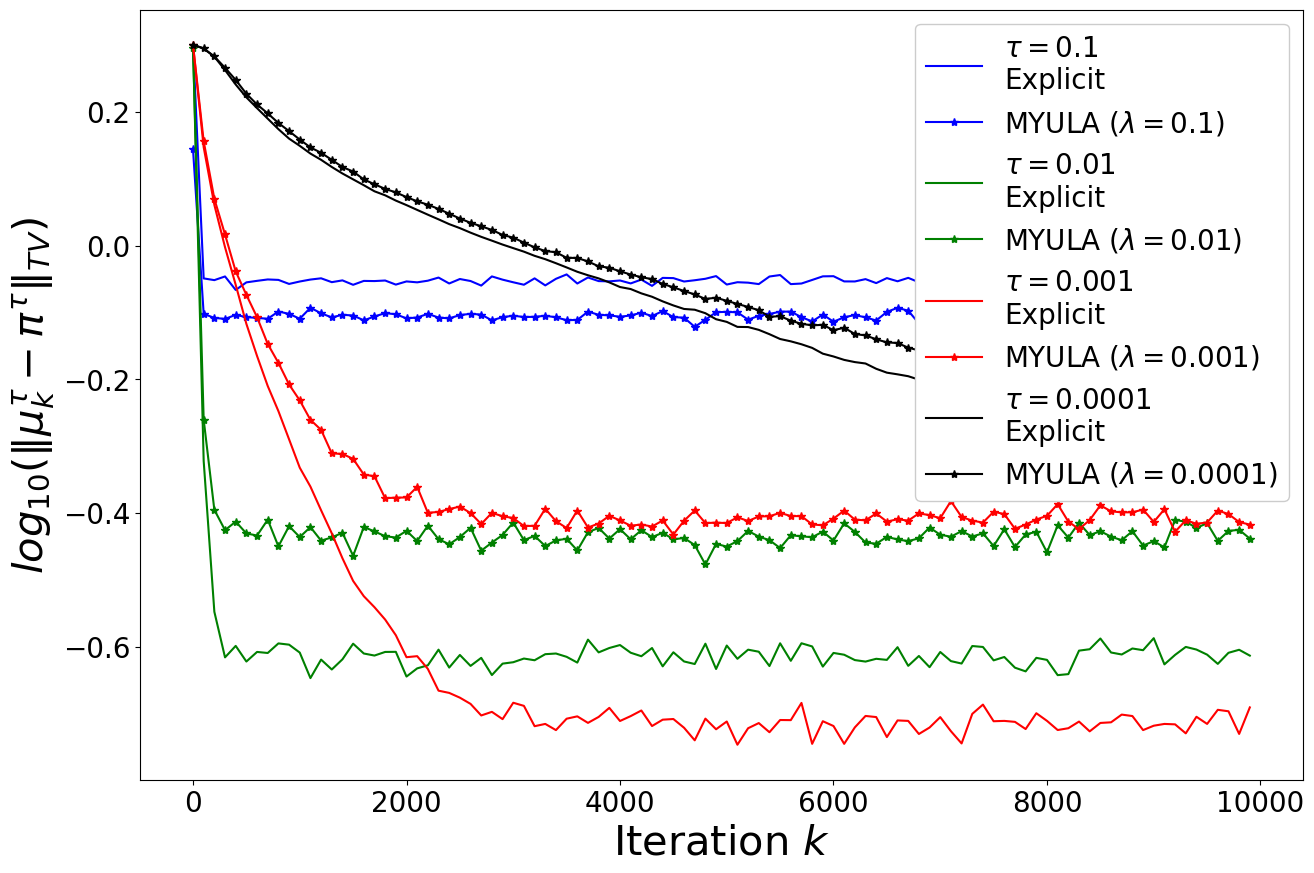

In [31]:
f = plt.figure(figsize=(15,10))
show_n=int(10000/step)
x_axis=np.arange(stop=show_n*step,step=step)

c = ['b', 'g','r' , 'k', 'y']


for tau_num,tau in enumerate(tau_list):
    plt.plot(x_axis,np.log10((tv[0,tau_num,:show_n])),c[tau_num]+'-',label=r'$\tau = $'+str(tau)+'\n'+'Explicit')
    plt.plot(x_axis,np.log10((tv[1,tau_num,:show_n])),c[tau_num]+'-*',label=rf'MYULA $(\lambda={ld_list[tau_num]})$')
    
    
matplotlib.rcParams.update({'font.size': 20})
plt.xlabel('Iteration $k$',fontsize=30)
plt.ylabel(r'$log_{10}(\|\mu_k^\tau-\pi^\tau\|_{TV})$',fontsize=30)
plt.legend(loc='upper right',framealpha=1,fontsize=20)

folder = Path('results/images_paper/')
folder.mkdir(parents=True, exist_ok=True)
plt.savefig('results/images_paper/TV_convergence_rates_2d_K.png')